In [1]:
box = 'Box5_1400'
param_names = ['d','e','f','g']
ndim = len(param_names)

In [2]:
from utils import *
from massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [3]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [4]:
cosmo = cosmo_params[box]
mass_function = MassFunction(cosmo)

In [5]:
h = cosmo['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [6]:
a_fit = 1.0

In [7]:
N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm([a_fit]):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/1 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and cal

In [8]:
a_list = list(NvMs.keys())

from scipy.stats import poisson


M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [9]:
jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
poisson_err = {a:np.sqrt(N_data[a]) for a in N_data}

weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov}  
# inv_weighted_cov = {a:np.diag([1 for _ in range(len(weighted_cov[a]))]) for a in weighted_cov}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [10]:
def uniform_log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(param < 0 or param > 10):
            return -np.inf
    return 0

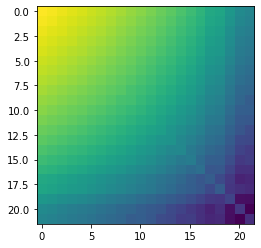

In [11]:
plt.imshow(np.log(weighted_cov[a]))

/tmp/ipykernel_14360/4174462246.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(inv_weighted_cov[a]))


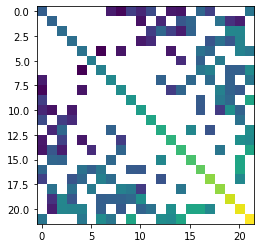

In [12]:
plt.imshow(np.log(inv_weighted_cov[a]))

(22,)
asdf 146525.32718771152
-73290.26127817812
[0.]


NameError: name 'result' is not defined

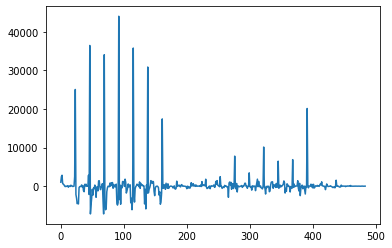

In [13]:
tmp_params = {'d': 0.43, 'e': 1.1152988509826565, 'f': 2.4674894021012355, 'g': 1.3297850427931441}

params = tmp_params

tinker_fs = {}

for a in N_data:
    tinker_eval = [mass_function.tinker(a, M_c, **params)*vol for M_c in M_numerics]
    f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    tinker_fs[a] = f_dndlogM

model_vals = {}
for a in N_data:
    if(scaleToRedshift(a) >=2):
        continue
    model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
        for edge_pair in NvMs[a]['edge_pairs']
    ])


residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
print(residuals[a].shape)
print('asdf', np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]))
ASDF = []
for i in range(len(residuals[a])):
    for j in range(len(residuals[a])):
#         print(residuals[a][i], residuals[a][j])
        ASDF += [residuals[a][i] * residuals[a][j] * inv_weighted_cov[a][i][j]]
plt.plot(ASDF)
log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
             for a in model_vals]
print(np.sum(log_probs))
print(np.exp(log_probs))
ASDF = np.sum(log_probs)

params = dict(zip(param_names, result['x']))

tinker_fs = {}

for a in N_data:
    tinker_eval = [mass_function.tinker(a, M_c, **params)*vol for M_c in M_numerics]
    f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    tinker_fs[a] = f_dndlogM

model_vals = {}
for a in N_data:
    if(scaleToRedshift(a) >=2):
        continue
    model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
        for edge_pair in NvMs[a]['edge_pairs']
    ])


residuals = {a: model_vals[a]-N_data[a] for a in model_vals}

ASDF2 = []
for i in range(len(residuals[a])):
    for j in range(len(residuals[a])):
#         print(residuals[a][i], residuals[a][j])
        ASDF2 += [residuals[a][i] * residuals[a][j] * inv_weighted_cov[a][i][j]]
plt.plot(ASDF2, alpha=0.55)

print('asdf', np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]))
log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) ) 
             for a in model_vals]
print(np.sum(log_probs))
print(np.exp(log_probs))

# plt.xscale('log')
print(len(residuals[a]))
plt.yscale('symlog', linscale=1e-20)
plt.legend()
plt.xlim(-1,56)
# plt.axvline(0)
# plt.axvline(23)
# plt.axvline(46)
print((ASDF)> np.sum(log_probs))

In [14]:
def is_positive_definite(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # Check if the matrix is symmetric
    if not np.allclose(matrix, matrix.T):
        return False

    # Check if all eigenvalues are positive
    eigenvalues, _ = np.linalg.eig(matrix)
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [15]:
is_positive_definite(inv_weighted_cov[a])

True

In [16]:
is_positive_definite(weighted_cov[a])

True

In [17]:
def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(uniform_log_prior(param_values) == -np.inf):
        return -np.inf

    params = dict(zip(param_names, param_values))

    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [mass_function.tinker(a, M_c, **params)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
        if(scaleToRedshift(a) >=2):
            continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)


In [18]:
def log_likelihood(param_values):
    lp = uniform_log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [19]:
guess = np.random.uniform(low=0, high=5, size=(len(param_names)))

In [23]:
print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="Nelder-Mead", 
                           bounds = [(0,10) for _ in range(ndim)],
                           options={
                               'maxiter': len(guess)*10000})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Starting ML Fit
Box5_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 35034.77245014451
             x: [ 2.024e+00  1.642e+00  2.986e-01  1.441e+00]
           nit: 179
          nfev: 304
 final_simplex: (array([[ 2.024e+00,  1.642e+00,  2.986e-01,  1.441e+00],
                       [ 2.024e+00,  1.642e+00,  2.986e-01,  1.441e+00],
                       ...,
                       [ 2.024e+00,  1.642e+00,  2.986e-01,  1.441e+00],
                       [ 2.024e+00,  1.642e+00,  2.986e-01,  1.441e+00]]), array([ 3.503e+04,  3.503e+04,  3.503e+04,  3.503e+04,
                        3.503e+04]))
   param_names: ['d', 'e', 'f', 'g']
[2.02444629 1.64217447 0.29861527 1.44091678]


In [24]:
MLE_params = dict(zip(param_names, result['x']))
print(MLE_params)

{'d': 2.0244462886278765, 'e': 1.6421744701682843, 'f': 0.29861527181325165, 'g': 1.4409167845064725}


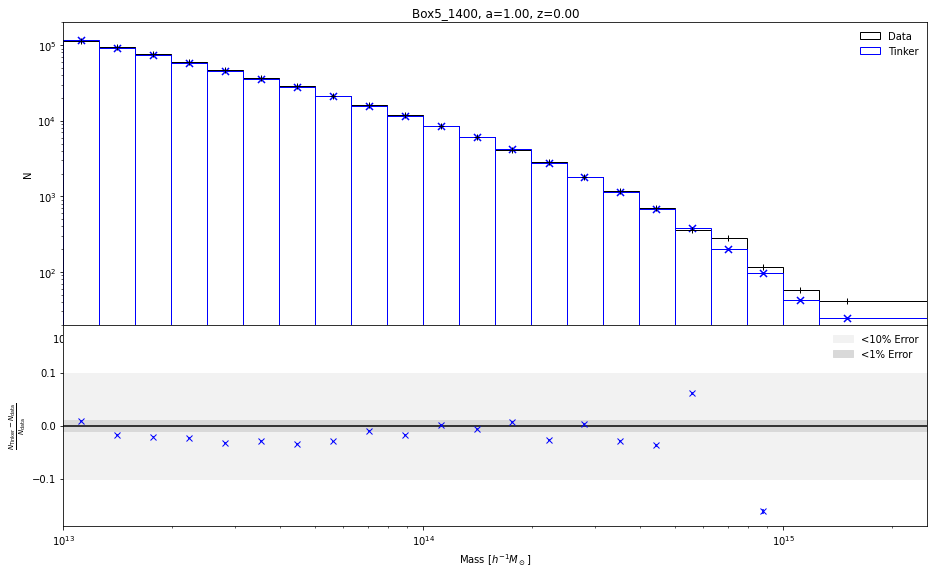

In [25]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
c_params = MLE_params
a = a_fit

fig1 = plt.figure(figsize =(12, 7))

axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
Pk = mass_function.Pka[a]
c_data = NvMs[a]

Ms = M_data[a]
N = N_data[a]
edge_pairs = c_data['edge_pairs']

edges = [edge[0] for edge in edge_pairs]
edges += [edge_pairs[-1][1]]

yerr = yerr_dict[a]
dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params)*vol for M_c in M_numerics]
f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

edges = np.array(edges)
axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

y1 = 0.1*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.1*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

c_Ms = np.append(Ms, edges[-1])
c_Ms = np.append(edges[0], c_Ms)
axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

y1 = 0.01*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.01*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)
axs[0].set_ylabel('N')

axs[1].set_xscale('log')
# axs[1].set_yscale('lin', linthresh=1e-2)    
axs[1].legend(frameon=False)
axs[1].axhline(0, c='black')
axs[1].set_ylabel('N')
axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
axs[0].set_ylim(20, 2e5)
axs[0].set_xlim((1e13, np.max(edges)))
axs[1].set_xlim((1e13, np.max(edges)))
axs[1].set_ylim((-.19, .19))
axs[1].set_yticks([-.1, 0, .1])
# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, a), bbox_inches='tight')

In [ ]:
print(log_likelihood([0.43, 1.1152988509826565, 2.4674894021012355,  1.3297850427931441])) #ffrom n50_0
print(log_likelihood(result['x']))

In [ ]:
nwalkers = 64
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, ndim))


from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 1000, progress=True);

In [ ]:
labels = param_names

import corner
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_corner.pdf'%(box), bbox_inches='tight')

In [ ]:
labels = param_names

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(result['x'][i], color='red')
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_convergence.pdf'%(box), bbox_inches='tight')

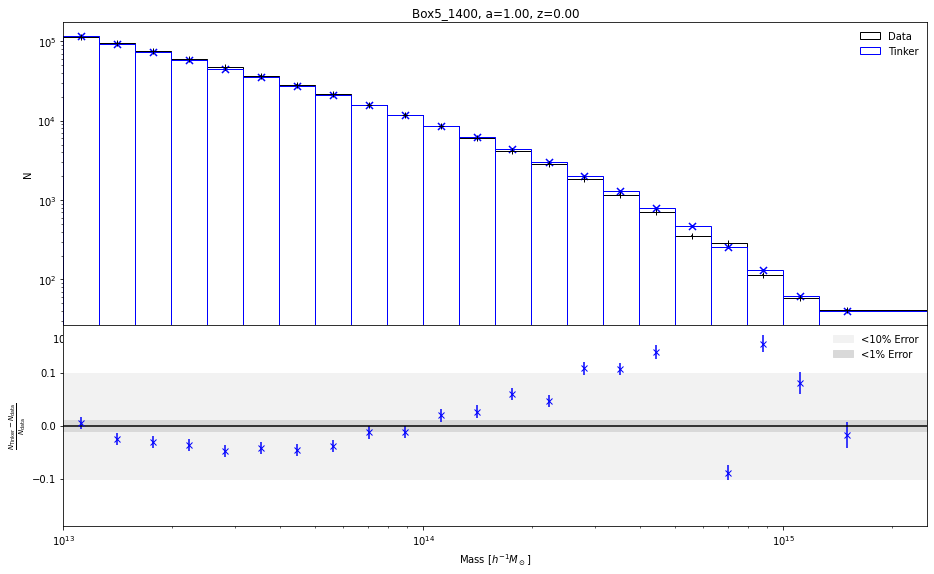

In [89]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
c_params = {'d': 0.43, 'e': 1.1152988509826565, 'f': 2.4674894021012355, 'g': 1.3297850427931441}
a = a_fit

fig1 = plt.figure(figsize =(12, 7))

axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
Pk = mass_function.Pka[a]
c_data = NvMs[a]

Ms = M_data[a]
N = N_data[a]
edge_pairs = c_data['edge_pairs']

edges = [edge[0] for edge in edge_pairs]
edges += [edge_pairs[-1][1]]

yerr = yerr_dict[a]
dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params)*vol for M_c in M_numerics]
#             print(tinker_eval_MCMC)

#             f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
#             f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

edges = np.array(edges)
axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

y1 = 0.1*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.1*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

c_Ms = np.append(Ms, edges[-1])
c_Ms = np.append(edges[0], c_Ms)
axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

y1 = 0.01*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.01*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)
axs[0].set_ylabel('N')

axs[1].set_xscale('log')
# axs[1].set_yscale('symlog', linthresh=1e-2)    
axs[1].legend(frameon=False)
axs[1].axhline(0, c='black')
axs[1].set_ylabel('N')
axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

axs[0].set_xlim((1e13, np.max(edges)))
axs[1].set_xlim((1e13, np.max(edges)))
axs[1].set_ylim((-.19, .19))
axs[1].set_yticks([-.1, 0, .1])
# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, a), bbox_inches='tight')

In [ ]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_MCMC_sampler.pkl"%(box, a_fit), "wb") as f:
    pickle.dump(sampler, f)

In [ ]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a_fit), "wb") as f:
    pickle.dump(params_final, f)

In [ ]:
params_final.values()